In [1]:
using Optimization, OptimizationOptimJL, Plots
using ModelingToolkit, IntervalSets
using Sophon
using ChainRulesCore

@parameters t, x
@variables u(..), ρ(..), p(..)
Dₓ = Differential(x)
Dₜ = Differential(t)

u₀(x) = 0.0
ρ₀(x) = ifelse(x < 0.5, 1.0, 0.125)
@register ρ₀(x)
p₀(x) = ifelse(x < 0.5, 1.0, 0.1)
@register p₀(x)

bcs = [ρ(0, x) ~ ρ₀(x), u(0, x) ~ u₀(x), p(0, x) ~ p₀(x), u(t, 0) ~ 0.0, u(t, 1) ~ 0.0]

γ = 1.4
E(t, x) = p(t, x) / (γ - 1) + 0.5 * ρ(t, x) * abs2(u(t, x))

eqs = [
    Dₜ(ρ(t, x)) + Dₓ(ρ(t, x) * u(t, x)) ~ 0.0,
    Dₜ(ρ(t, x) * u(t, x)) + Dₓ(ρ(t, x) * u(t, x) * u(t, x) + p(t, x)) ~ 0.0,
    Dₜ(E(t, x)) + Dₓ(u(t, x) * (E(t, x) + p(t, x))) ~ 0.0,
]

t_min, t_max = 0.0, 0.2
x_min, x_max = 0.0, 1.0
domains = [t ∈ Interval(t_min, t_max), x ∈ Interval(x_min, x_max)]

@named pde_system = PDESystem(eqs, bcs, domains, [t, x], [u(t, x), ρ(t, x), p(t, x)])

In [ ]:
pinn = PINN(u=FullyConnected(2, 1, tanh; num_layers=4, hidden_dims=16),
            ρ=FullyConnected(2, 1, tanh; num_layers=4, hidden_dims=16),
            p=FullyConnected(2, 1, tanh; num_layers=4, hidden_dims=16))

sampler = QuasiRandomSampler(1000, 400)

function pde_weights(phi, x, θ)
    ux = Sophon.finitediff(phi.u, x, θ.u, 1, 1)
    ρx = Sophon.finitediff(phi.ρ, x, θ.ρ, 1, 1)
    px = Sophon.finitediff(phi.p, x, θ.p, 1, 1)
    d = ux .+ ρx .+ px

    return ChainRulesCore.@ignore_derivatives inv.(0.2 .* abs.(d) .+ 1)
end

strategy = AdaptiveTraining(pde_weights, Returns(10))
prob = Sophon.discretize(pde_system, pinn, sampler, strategy)

res = Optimization.solve(prob, BFGS(); maxiters=1000)

In [ ]:
res.objective

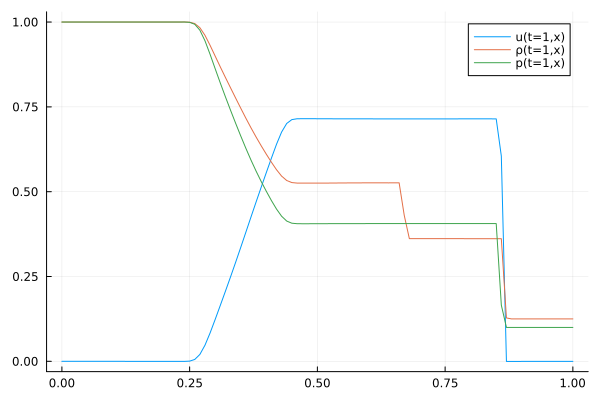

In [16]:
using Plots
θ = res.u
phi = pinn.phi
xs = x_min:0.01:x_max

phi = pinn.phi
p1 = plot(xs, [first(phi.u([t_max, x], θ.u)) for x in xs]; label="u(t=1,x)")
p2 = plot!(xs, [first(phi.ρ([t_max, x], θ.ρ)) for x in xs]; label="ρ(t=1,x)")
p3 = plot!(xs, [first(phi.p([t_max, x], θ.p)) for x in xs]; label="p(t=1,x)")